CIFAR

In [1]:
import torch
import os
import opacus
import copy
import torchvision
import torchattacks

import numpy as np
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from tqdm import tqdm
from datetime import datetime
from opacus.validators import ModuleValidator


from model import ResNet9, initialize_weights
from torchvision import models


CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD_DEV = (0.2023, 0.1994, 0.2010)

def accuracy(preds, labels):
    return (preds == labels).mean()

class Experiment:
    def __init__(self, batch_size, epochs, patience, adv_attack, adv_attack_mode, epsilon, dp, device, save_experiment,
                 verbose, adv_test=True, name=None):
        # self.model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
        self.model = ResNet9(norm_layer="group")
        self.adv_model = ResNet9(norm_layer="group").to(device)
        self.optimizer = optim.NAdam(self.model.parameters())
        self.criterion = nn.CrossEntropyLoss()
        self.batch_size = batch_size
        self.epochs = epochs
        self.patience = patience
        self.adv_attack = adv_attack
        self.adv_attack_mode = adv_attack_mode
        self.epsilon = epsilon
        self.dp = dp
        self.device = device
        self.verbose = verbose
        self.disable_tqdm = not self.verbose
        self.save_experiment = save_experiment
        self.adv_test = adv_test
        self.best_model_weights = None

        if name is None:
            adv_s = f"adv-{epsilon}-{adv_attack_mode}" if adv_attack is not None else "non_adv"
            dp_s = "dp" if dp else "non_dp"
            self.name = f"{adv_s}+{dp_s}+{batch_size}"
        else:
            self.name = name

        now = datetime.now()
        formatted_timestamp = now.strftime("%d-%m-%Y_%H:%M:%S")
        self.dir_name = f"results/{self.name}_{formatted_timestamp}"
        if self.save_experiment:
            os.makedirs(self.dir_name, exist_ok=True)

        self._setup_training()

    def _log(self, message):
        # if self.verbose:
        print(f"Experiment {self.name}: {message}")

    def _setup_training(self):
        self._log("Loading data")
        transform = transforms.Compose(
            [transforms.ToTensor(),
              transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD_DEV)
             ])
        
        learning_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

        self.train_loader = torch.utils.data.DataLoader(learning_set, batch_size=self.batch_size, shuffle=True, num_workers=2)

        test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
        self.test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False, num_workers=2)

        self.classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

        if self.dp:
            self._log("DP on")
            self.privacy_engine = opacus.PrivacyEngine()
            self.model = ModuleValidator.fix(self.model)
            self.optimizer = optim.NAdam(self.model.parameters())
            self.model, self.optimizer, self.train_loader = self.privacy_engine.make_private_with_epsilon(
                module=self.model,
                optimizer=self.optimizer,
                data_loader=self.train_loader,
                epochs=self.epochs,
                target_epsilon=7.5,
                target_delta=1e-5,
                max_grad_norm=1.5,
            )
        else:
            self._log("DP off")
            
    
    def _fgsm_attack_per_sample(self, inputs, targets):
        inputs, targets = inputs.to(self.device), targets.to(self.device)
        adv_images = torch.empty_like(inputs)
        if self.dp:
            self.adv_model.load_state_dict(copy.deepcopy(self.model._module.state_dict()))
            attack = torchattacks.FGSM(self.adv_model, eps=self.epsilon)
        else:
            attack = torchattacks.FGSM(self.model, eps=self.epsilon)
        for i in range(len(inputs)):
            sample = torch.unsqueeze(inputs[i], dim=0)
            sample_target = targets[i:i + 1]

            # plt.imshow(np.transpose(sample.squeeze().detach().cpu().numpy(), (1, 2, 0)))
            # plt.show()
            # plt.imshow(np.transpose(adv_image.squeeze().detach().cpu().numpy(), (1, 2, 0)))
            # plt.show()
            adv_images[i] = attack(sample, sample_target)

        # imshow(torchvision.utils.make_grid(adv_images).cpu())
        # imshow(torchvision.utils.make_grid(inputs).cpu())
        # print(' '.join(f'{classes[targets[j]]:5s}' for j in range(BATCH_SIZE)))

        adv_images.to(self.device)
        # print(adv_images.shape, inputs.shape)
        return adv_images, targets

    def _fgsm_attack_batch(self, inputs, targets):
        inputs, targets = inputs.to(self.device), targets.to(self.device)
        if self.dp:
            self.adv_model.load_state_dict(copy.deepcopy(self.model._module.state_dict()))
            attack = torchattacks.FGSM(self.adv_model, eps=self.epsilon)
        else:
            attack = torchattacks.FGSM(self.model, eps=self.epsilon)
    
        perturbed_inputs = attack(inputs, targets)
        
#         plt.imshow(np.transpose(torchvision.utils.make_grid(perturbed_inputs).cpu().numpy(), (1, 2, 0)))
#         plt.show()
#         plt.imshow(np.transpose(torchvision.utils.make_grid(inputs).cpu().numpy(), (1, 2, 0)))
#         plt.show()
#         print(' '.join(f'{self.classes[targets[j]]:5s}' for j in range(self.batch_size)))
        
        return perturbed_inputs, targets

    def _run_epoch(self, data_loader):
        self.model.train()

        losses = []
        top1_acc = []

        for inputs, targets in tqdm(data_loader, disable=self.disable_tqdm):
            if self.adv_attack:
                if self.adv_attack_mode == 'batch':
                    inputs, targets = self._fgsm_attack_batch(inputs, targets)
                else:
                    inputs, targets = self._fgsm_attack_per_sample(inputs, targets)
            else:
                inputs, targets = inputs.to(self.device), targets.to(self.device)

            self.optimizer.zero_grad()

            output = self.model(inputs)
            loss = self.criterion(output, targets)
            
            preds = np.argmax(output.detach().cpu().numpy(), axis=1)
            labels = targets.detach().cpu().numpy()

            acc = accuracy(preds, labels)

            losses.append(loss.item())
            top1_acc.append(acc)

            loss.backward()
            self.optimizer.step()
            
        epsilon = self.privacy_engine.get_epsilon(1e-5)
        print(epsilon)
        return np.mean(losses), np.mean(top1_acc)


    def _fit(self):
        self._log("Training started")
        _ = self.model.to(self.device)
        _ = self.model.apply(initialize_weights)

        curr_patience = 0
        max_acc = 0

        val_losses = []
        val_accuracies = []
        train_losses = []
        train_accuracies = []

        for epoch in range(self.epochs):

            train_loss, train_acc = self._run_epoch(self.train_loader)
            self._log(f"Epoch {epoch + 1: >3}/{self.epochs}, train loss: {train_loss:.2e}, train acc: {train_acc:.3f}")

            train_losses.append(train_loss)
            train_accuracies.append(train_acc)
            
            if train_acc > max_acc:
                max_acc = train_acc
                self.best_model_weights = copy.deepcopy(self.model.state_dict())
                if self.save_experiment:
                    torch.save(self.model.state_dict(), f"{self.dir_name}/{self.name}.pt")

        self.model.load_state_dict(self.best_model_weights)

        self._log("Training finished")
        epsilon = self.privacy_engine.get_epsilon(1e-5)
        print(epsilon)

        plt.plot(range(len(train_losses)), np.array(train_losses))
        plt.title('train loss')
        if self.save_experiment:
            plt.savefig(f"{self.dir_name}/train_loss.png")
        if self.verbose:
            plt.show()
        else:
            plt.clf()

        plt.plot(range(len(train_accuracies)), np.array(train_accuracies))
        plt.title('train acc')
        if self.save_experiment:
            plt.savefig(f"{self.dir_name}/train_acc.png")
        if self.verbose:
            plt.show()
        else:
            plt.clf()

    def _validate(self, data_loader):
        self.model.eval()
        epoch_acc = 0.0
        epoch_acc_top5 = 0.0
        epoch_loss = 0.0

        with torch.no_grad():
            for inputs, targets in data_loader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs = self.model(inputs)

                loss = self.criterion(outputs, targets)

                top1 = torch.argmax(outputs, dim=1).long()
                n_correct = torch.sum(top1 == targets)

                _, top5 = torch.topk(outputs, 5, dim=1)
                top5 = top5.t()
                correct = top5.eq(targets.reshape(1, -1).expand_as(top5))
                n_correct_top5 = correct[:5].reshape(-1).float().sum(0, keepdim=True)

                epoch_loss += loss.item()
                epoch_acc += n_correct.item()
                epoch_acc_top5 += n_correct_top5.item()

            epoch_loss /= len(data_loader.dataset)
            epoch_acc /= len(data_loader.dataset)
            epoch_acc_top5 /= len(data_loader.dataset)

        return epoch_loss, epoch_acc, epoch_acc_top5

    def test(self, eps, data_loader):
        correct = 0
        adv_examples = []
        self.model.eval()

        if self.dp:
            self.adv_model.load_state_dict(copy.deepcopy(self.model._module.state_dict()))
            attack = torchattacks.FGSM(self.adv_model, eps=eps)
        else:
            attack = torchattacks.FGSM(self.model, eps=eps)

        for data, target in tqdm(data_loader, disable=self.disable_tqdm):
            data, target = data.to(self.device), target.to(self.device)

            output = self.model(data)
            init_pred = torch.argmax(output, dim=1).long()

            if init_pred.item() != target.item():
                continue

            perturbed_inputs = attack(data, target)
            output = self.model(perturbed_inputs)

            final_pred = torch.argmax(output, dim=1).long()
            if final_pred.item() == target.item():
                correct += 1

                if (eps == 0) and (len(adv_examples) < 5):
                    adv_ex = perturbed_inputs.squeeze().detach().cpu().numpy()
                    adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))
            else:
                if len(adv_examples) < 5:
                    adv_ex = perturbed_inputs.squeeze().detach().cpu().numpy()
                    adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))

        final_acc = correct / float(len(data_loader))
        self._log(
            "Epsilon: {}\tTest Accuracy = {} / {} = {}".format(eps, correct, len(data_loader), final_acc))
        return final_acc, adv_examples



cuda
Experiment non_adv+dp+1024: Loading data
Files already downloaded and verified
Files already downloaded and verified
Experiment non_adv+dp+1024: DP on


/home/anna/miniconda3/envs/ap/lib/python3.10/site-packages/opacus/privacy_engine.py:141: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/home/anna/miniconda3/envs/ap/lib/python3.10/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


Experiment non_adv+dp+1024: Training started


  0%|                                                      | 0/49 [00:00<?, ?it/s]/home/anna/miniconda3/envs/ap/lib/python3.10/site-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
100%|█████████████████████████████████████████████| 49/49 [00:16<00:00,  3.04it/s]


2.6516377876383403
Experiment non_adv+dp+1024: Epoch   1/25, train loss: 2.81e+00, train acc: 0.244


100%|█████████████████████████████████████████████| 49/49 [00:14<00:00,  3.45it/s]


3.049062174160057
Experiment non_adv+dp+1024: Epoch   2/25, train loss: 1.98e+00, train acc: 0.379


100%|█████████████████████████████████████████████| 49/49 [00:14<00:00,  3.42it/s]


3.3695191026322946
Experiment non_adv+dp+1024: Epoch   3/25, train loss: 1.80e+00, train acc: 0.452


100%|█████████████████████████████████████████████| 49/49 [00:14<00:00,  3.41it/s]


3.6558325276236547
Experiment non_adv+dp+1024: Epoch   4/25, train loss: 1.75e+00, train acc: 0.488


100%|█████████████████████████████████████████████| 49/49 [00:14<00:00,  3.33it/s]


3.915523007989198
Experiment non_adv+dp+1024: Epoch   5/25, train loss: 1.70e+00, train acc: 0.510


100%|█████████████████████████████████████████████| 49/49 [00:14<00:00,  3.39it/s]


4.158584610512357
Experiment non_adv+dp+1024: Epoch   6/25, train loss: 1.60e+00, train acc: 0.541


100%|█████████████████████████████████████████████| 49/49 [00:14<00:00,  3.35it/s]


4.3880040146219255
Experiment non_adv+dp+1024: Epoch   7/25, train loss: 1.61e+00, train acc: 0.556


100%|█████████████████████████████████████████████| 49/49 [00:14<00:00,  3.36it/s]


4.60484266313402
Experiment non_adv+dp+1024: Epoch   8/25, train loss: 1.59e+00, train acc: 0.566


100%|█████████████████████████████████████████████| 49/49 [00:14<00:00,  3.32it/s]


4.813398392225429
Experiment non_adv+dp+1024: Epoch   9/25, train loss: 1.56e+00, train acc: 0.582


100%|█████████████████████████████████████████████| 49/49 [00:14<00:00,  3.35it/s]


5.0159740020153
Experiment non_adv+dp+1024: Epoch  10/25, train loss: 1.54e+00, train acc: 0.593


100%|█████████████████████████████████████████████| 49/49 [00:14<00:00,  3.36it/s]


5.208785239333664
Experiment non_adv+dp+1024: Epoch  11/25, train loss: 1.48e+00, train acc: 0.608


100%|█████████████████████████████████████████████| 49/49 [00:14<00:00,  3.33it/s]


5.397324006150258
Experiment non_adv+dp+1024: Epoch  12/25, train loss: 1.46e+00, train acc: 0.615


100%|█████████████████████████████████████████████| 49/49 [00:14<00:00,  3.35it/s]


5.580067154794406
Experiment non_adv+dp+1024: Epoch  13/25, train loss: 1.39e+00, train acc: 0.631


100%|█████████████████████████████████████████████| 49/49 [00:14<00:00,  3.37it/s]


5.757976293745034
Experiment non_adv+dp+1024: Epoch  14/25, train loss: 1.41e+00, train acc: 0.634


100%|█████████████████████████████████████████████| 49/49 [00:14<00:00,  3.34it/s]


5.931432361168287
Experiment non_adv+dp+1024: Epoch  15/25, train loss: 1.34e+00, train acc: 0.652


100%|█████████████████████████████████████████████| 49/49 [00:14<00:00,  3.34it/s]


6.101690773691344
Experiment non_adv+dp+1024: Epoch  16/25, train loss: 1.34e+00, train acc: 0.657


100%|█████████████████████████████████████████████| 49/49 [00:14<00:00,  3.37it/s]


6.2665215901166755
Experiment non_adv+dp+1024: Epoch  17/25, train loss: 1.33e+00, train acc: 0.660


100%|█████████████████████████████████████████████| 49/49 [00:14<00:00,  3.35it/s]


6.431352406542007
Experiment non_adv+dp+1024: Epoch  18/25, train loss: 1.34e+00, train acc: 0.666


100%|█████████████████████████████████████████████| 49/49 [00:14<00:00,  3.36it/s]


6.588623452378315
Experiment non_adv+dp+1024: Epoch  19/25, train loss: 1.34e+00, train acc: 0.669


100%|█████████████████████████████████████████████| 49/49 [00:14<00:00,  3.36it/s]


6.745395266099074
Experiment non_adv+dp+1024: Epoch  20/25, train loss: 1.33e+00, train acc: 0.670


100%|█████████████████████████████████████████████| 49/49 [00:14<00:00,  3.36it/s]


6.9008280000842985
Experiment non_adv+dp+1024: Epoch  21/25, train loss: 1.30e+00, train acc: 0.677


100%|█████████████████████████████████████████████| 49/49 [00:14<00:00,  3.36it/s]


7.0500296780898015
Experiment non_adv+dp+1024: Epoch  22/25, train loss: 1.28e+00, train acc: 0.681


100%|█████████████████████████████████████████████| 49/49 [00:14<00:00,  3.35it/s]


7.1992313560953045
Experiment non_adv+dp+1024: Epoch  23/25, train loss: 1.31e+00, train acc: 0.681


100%|█████████████████████████████████████████████| 49/49 [00:14<00:00,  3.36it/s]


7.348211784993296
Experiment non_adv+dp+1024: Epoch  24/25, train loss: 1.28e+00, train acc: 0.689


100%|█████████████████████████████████████████████| 49/49 [00:14<00:00,  3.36it/s]


7.490268977994677
Experiment non_adv+dp+1024: Epoch  25/25, train loss: 1.27e+00, train acc: 0.692
Experiment non_adv+dp+1024: Training finished
7.490268977994677


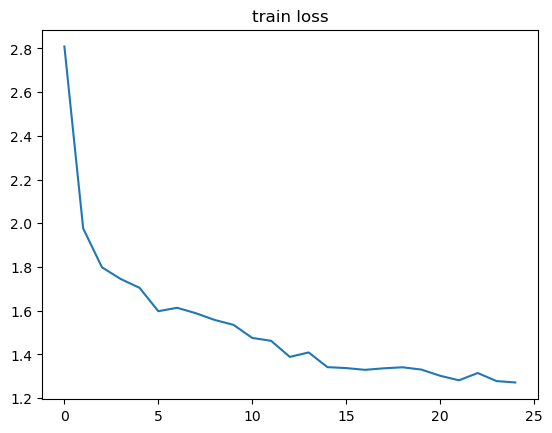

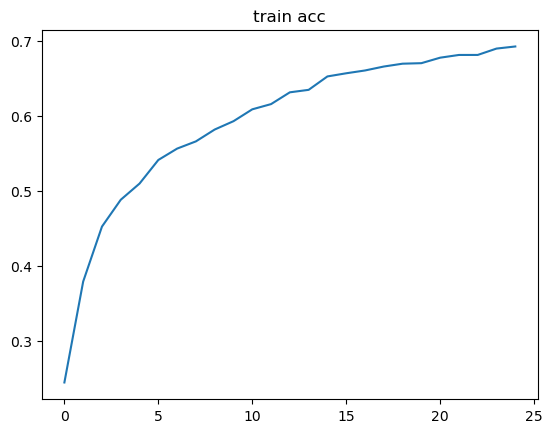

In [2]:
#eps 7.5
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

batch_size=1024
adv_attack_mode ='batch'
epsilon=0.1
dp=True
epochs = 25
patience = 25
save_experiment=False 
verbose=True

adv_attack = None

experiment = Experiment(
    batch_size=batch_size, 
    epochs=epochs, 
    patience=patience, 
    adv_attack=adv_attack, 
    adv_attack_mode=None, 
    epsilon=epsilon, 
    dp=dp, 
    device=device, 
    save_experiment=save_experiment, 
    verbose=verbose, 
    adv_test=True)

experiment._fit()

In [3]:
experiment.optimizer.noise_multiplier

0.8251953125

In [4]:
experiment._validate(experiment.train_loader)

(0.0011879352474212647, 0.70428, 0.972)

In [5]:
experiment._validate(experiment.test_loader)

(1.3800779017518017, 0.6636, 0.9631)

cuda
Experiment non_adv+dp+1024: Loading data
Files already downloaded and verified
Files already downloaded and verified
Experiment non_adv+dp+1024: DP on
Experiment non_adv+dp+1024: Training started


100%|█████████████████████████████████████████████| 49/49 [00:31<00:00,  1.56it/s]


3.027943831972982
Experiment non_adv+dp+1024: Epoch   1/25, train loss: 2.81e+00, train acc: 0.254


100%|█████████████████████████████████████████████| 49/49 [00:31<00:00,  1.55it/s]


3.4835990035282483
Experiment non_adv+dp+1024: Epoch   2/25, train loss: 1.93e+00, train acc: 0.395


100%|█████████████████████████████████████████████| 49/49 [00:31<00:00,  1.55it/s]


3.855019175278393
Experiment non_adv+dp+1024: Epoch   3/25, train loss: 1.86e+00, train acc: 0.450


100%|█████████████████████████████████████████████| 49/49 [00:31<00:00,  1.56it/s]


4.178283301839848
Experiment non_adv+dp+1024: Epoch   4/25, train loss: 1.74e+00, train acc: 0.495


100%|█████████████████████████████████████████████| 49/49 [00:31<00:00,  1.57it/s]


4.4736441648209055
Experiment non_adv+dp+1024: Epoch   5/25, train loss: 1.68e+00, train acc: 0.521


100%|█████████████████████████████████████████████| 49/49 [00:31<00:00,  1.53it/s]


4.7494821699369005
Experiment non_adv+dp+1024: Epoch   6/25, train loss: 1.64e+00, train acc: 0.542


100%|█████████████████████████████████████████████| 49/49 [00:31<00:00,  1.55it/s]


5.006994827856302
Experiment non_adv+dp+1024: Epoch   7/25, train loss: 1.61e+00, train acc: 0.557


100%|█████████████████████████████████████████████| 49/49 [00:31<00:00,  1.55it/s]


5.251561267679487
Experiment non_adv+dp+1024: Epoch   8/25, train loss: 1.60e+00, train acc: 0.566


100%|█████████████████████████████████████████████| 49/49 [00:31<00:00,  1.57it/s]


5.48842055612963
Experiment non_adv+dp+1024: Epoch   9/25, train loss: 1.52e+00, train acc: 0.587


100%|█████████████████████████████████████████████| 49/49 [00:31<00:00,  1.56it/s]


5.713311983378917
Experiment non_adv+dp+1024: Epoch  10/25, train loss: 1.51e+00, train acc: 0.600


100%|█████████████████████████████████████████████| 49/49 [00:31<00:00,  1.56it/s]


5.931975910820257
Experiment non_adv+dp+1024: Epoch  11/25, train loss: 1.50e+00, train acc: 0.608


100%|█████████████████████████████████████████████| 49/49 [00:31<00:00,  1.57it/s]


6.143068358014471
Experiment non_adv+dp+1024: Epoch  12/25, train loss: 1.46e+00, train acc: 0.618


100%|█████████████████████████████████████████████| 49/49 [00:31<00:00,  1.56it/s]


6.349062196675928
Experiment non_adv+dp+1024: Epoch  13/25, train loss: 1.42e+00, train acc: 0.628


100%|█████████████████████████████████████████████| 49/49 [00:31<00:00,  1.57it/s]


6.547636768576481
Experiment non_adv+dp+1024: Epoch  14/25, train loss: 1.44e+00, train acc: 0.631


100%|█████████████████████████████████████████████| 49/49 [00:31<00:00,  1.56it/s]


6.745689615793724
Experiment non_adv+dp+1024: Epoch  15/25, train loss: 1.39e+00, train acc: 0.644


100%|█████████████████████████████████████████████| 49/49 [00:31<00:00,  1.55it/s]


6.932812979982629
Experiment non_adv+dp+1024: Epoch  16/25, train loss: 1.33e+00, train acc: 0.656


100%|█████████████████████████████████████████████| 49/49 [00:31<00:00,  1.56it/s]


7.119936344171532
Experiment non_adv+dp+1024: Epoch  17/25, train loss: 1.36e+00, train acc: 0.657


100%|█████████████████████████████████████████████| 49/49 [00:31<00:00,  1.56it/s]


7.3037640608571754
Experiment non_adv+dp+1024: Epoch  18/25, train loss: 1.34e+00, train acc: 0.662


100%|█████████████████████████████████████████████| 49/49 [00:31<00:00,  1.58it/s]


7.480333747770451
Experiment non_adv+dp+1024: Epoch  19/25, train loss: 1.30e+00, train acc: 0.670


100%|█████████████████████████████████████████████| 49/49 [00:31<00:00,  1.58it/s]


7.656903434683726
Experiment non_adv+dp+1024: Epoch  20/25, train loss: 1.27e+00, train acc: 0.681


100%|█████████████████████████████████████████████| 49/49 [00:31<00:00,  1.56it/s]


7.832103844516558
Experiment non_adv+dp+1024: Epoch  21/25, train loss: 1.29e+00, train acc: 0.679


100%|█████████████████████████████████████████████| 49/49 [00:31<00:00,  1.55it/s]


7.998882619225279
Experiment non_adv+dp+1024: Epoch  22/25, train loss: 1.29e+00, train acc: 0.681


100%|█████████████████████████████████████████████| 49/49 [00:31<00:00,  1.57it/s]


8.165661393934004
Experiment non_adv+dp+1024: Epoch  23/25, train loss: 1.25e+00, train acc: 0.693


100%|█████████████████████████████████████████████| 49/49 [00:31<00:00,  1.56it/s]


8.332440168642725
Experiment non_adv+dp+1024: Epoch  24/25, train loss: 1.28e+00, train acc: 0.688


100%|█████████████████████████████████████████████| 49/49 [00:31<00:00,  1.55it/s]


8.49517261518174
Experiment non_adv+dp+1024: Epoch  25/25, train loss: 1.29e+00, train acc: 0.691
Experiment non_adv+dp+1024: Training finished
8.49517261518174


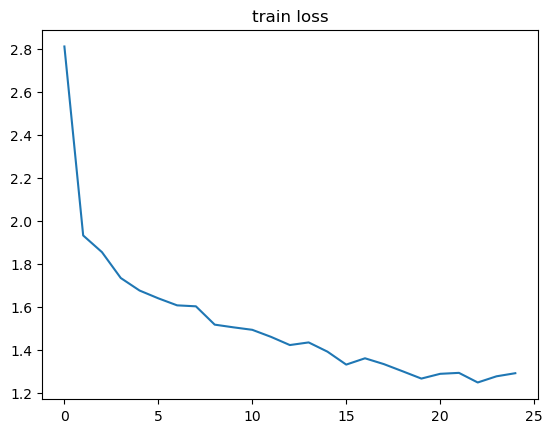

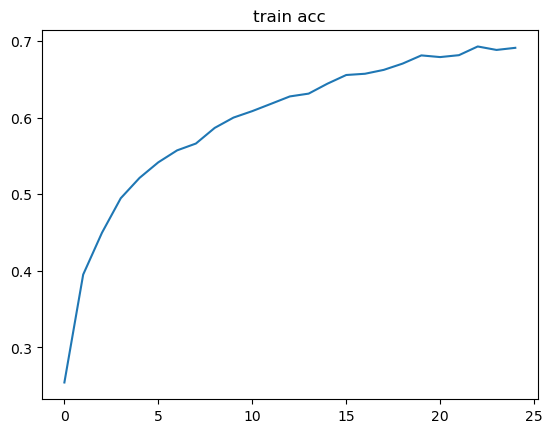

In [8]:
#eps 8.5
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

batch_size=1024
adv_attack_mode ='batch'
epsilon=0.1
dp=True
epochs = 25
patience = 25
save_experiment=False 
verbose=True

adv_attack = None

experiment = Experiment(
    batch_size=batch_size, 
    epochs=epochs, 
    patience=patience, 
    adv_attack=adv_attack, 
    adv_attack_mode=None, 
    epsilon=epsilon, 
    dp=dp, 
    device=device, 
    save_experiment=save_experiment, 
    verbose=verbose, 
    adv_test=True)

experiment._fit()

In [9]:
experiment._validate(experiment.test_loader)

(1.3757442510565323, 0.6655, 0.9646)

cuda
Experiment non_adv+dp+1024: Loading data
Files already downloaded and verified
Files already downloaded and verified


/home/anna/miniconda3/envs/ap/lib/python3.10/site-packages/opacus/privacy_engine.py:141: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/home/anna/miniconda3/envs/ap/lib/python3.10/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


Experiment non_adv+dp+1024: DP on
Experiment non_adv+dp+1024: Training started


  0%|                                                      | 0/49 [00:00<?, ?it/s]/home/anna/miniconda3/envs/ap/lib/python3.10/site-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
100%|█████████████████████████████████████████████| 49/49 [00:15<00:00,  3.10it/s]


0.6426615564697984
Experiment non_adv+dp+1024: Epoch   1/25, train loss: 2.50e+00, train acc: 0.261


100%|█████████████████████████████████████████████| 49/49 [00:14<00:00,  3.42it/s]


0.7671725178951382
Experiment non_adv+dp+1024: Epoch   2/25, train loss: 1.87e+00, train acc: 0.386


100%|█████████████████████████████████████████████| 49/49 [00:14<00:00,  3.40it/s]


0.8914602078468685
Experiment non_adv+dp+1024: Epoch   3/25, train loss: 1.74e+00, train acc: 0.442


100%|█████████████████████████████████████████████| 49/49 [00:14<00:00,  3.39it/s]


1.0019713470565221
Experiment non_adv+dp+1024: Epoch   4/25, train loss: 1.69e+00, train acc: 0.473


100%|█████████████████████████████████████████████| 49/49 [00:14<00:00,  3.38it/s]


1.110610447460559
Experiment non_adv+dp+1024: Epoch   5/25, train loss: 1.69e+00, train acc: 0.482


100%|█████████████████████████████████████████████| 49/49 [00:14<00:00,  3.35it/s]


1.2110330831471845
Experiment non_adv+dp+1024: Epoch   6/25, train loss: 1.67e+00, train acc: 0.501


100%|█████████████████████████████████████████████| 49/49 [00:14<00:00,  3.35it/s]


1.304012424124589
Experiment non_adv+dp+1024: Epoch   7/25, train loss: 1.61e+00, train acc: 0.521


100%|█████████████████████████████████████████████| 49/49 [00:14<00:00,  3.35it/s]


1.3936075465581876
Experiment non_adv+dp+1024: Epoch   8/25, train loss: 1.64e+00, train acc: 0.522


100%|█████████████████████████████████████████████| 49/49 [00:14<00:00,  3.36it/s]


1.4760937891018666
Experiment non_adv+dp+1024: Epoch   9/25, train loss: 1.58e+00, train acc: 0.540


100%|█████████████████████████████████████████████| 49/49 [00:14<00:00,  3.34it/s]


1.5585800316455456
Experiment non_adv+dp+1024: Epoch  10/25, train loss: 1.62e+00, train acc: 0.537


100%|█████████████████████████████████████████████| 49/49 [00:14<00:00,  3.34it/s]


1.6324768693953597
Experiment non_adv+dp+1024: Epoch  11/25, train loss: 1.60e+00, train acc: 0.547


100%|█████████████████████████████████████████████| 49/49 [00:14<00:00,  3.35it/s]


1.7055392696359526
Experiment non_adv+dp+1024: Epoch  12/25, train loss: 1.56e+00, train acc: 0.561


100%|█████████████████████████████████████████████| 49/49 [00:14<00:00,  3.36it/s]


1.7763417688438794
Experiment non_adv+dp+1024: Epoch  13/25, train loss: 1.53e+00, train acc: 0.571


100%|█████████████████████████████████████████████| 49/49 [00:14<00:00,  3.30it/s]


1.8448523379699113
Experiment non_adv+dp+1024: Epoch  14/25, train loss: 1.52e+00, train acc: 0.574


100%|█████████████████████████████████████████████| 49/49 [00:14<00:00,  3.33it/s]


1.9112237414210265
Experiment non_adv+dp+1024: Epoch  15/25, train loss: 1.57e+00, train acc: 0.574


100%|█████████████████████████████████████████████| 49/49 [00:14<00:00,  3.33it/s]


1.9757656456890382
Experiment non_adv+dp+1024: Epoch  16/25, train loss: 1.55e+00, train acc: 0.580


100%|█████████████████████████████████████████████| 49/49 [00:14<00:00,  3.34it/s]


2.038595491487863
Experiment non_adv+dp+1024: Epoch  17/25, train loss: 1.50e+00, train acc: 0.594


100%|█████████████████████████████████████████████| 49/49 [00:14<00:00,  3.34it/s]


2.0998324549163248
Experiment non_adv+dp+1024: Epoch  18/25, train loss: 1.49e+00, train acc: 0.599


100%|█████████████████████████████████████████████| 49/49 [00:14<00:00,  3.34it/s]


2.1596037696746215
Experiment non_adv+dp+1024: Epoch  19/25, train loss: 1.47e+00, train acc: 0.606


100%|█████████████████████████████████████████████| 49/49 [00:14<00:00,  3.35it/s]


2.218045901862494
Experiment non_adv+dp+1024: Epoch  20/25, train loss: 1.51e+00, train acc: 0.601


100%|█████████████████████████████████████████████| 49/49 [00:14<00:00,  3.35it/s]


2.2753059012766985
Experiment non_adv+dp+1024: Epoch  21/25, train loss: 1.46e+00, train acc: 0.609


100%|█████████████████████████████████████████████| 49/49 [00:14<00:00,  3.31it/s]


2.3313423806039455
Experiment non_adv+dp+1024: Epoch  22/25, train loss: 1.50e+00, train acc: 0.605


100%|█████████████████████████████████████████████| 49/49 [00:14<00:00,  3.34it/s]


2.3863954311513886
Experiment non_adv+dp+1024: Epoch  23/25, train loss: 1.48e+00, train acc: 0.615


100%|█████████████████████████████████████████████| 49/49 [00:14<00:00,  3.35it/s]


2.4403257375951344
Experiment non_adv+dp+1024: Epoch  24/25, train loss: 1.51e+00, train acc: 0.611


100%|█████████████████████████████████████████████| 49/49 [00:14<00:00,  3.35it/s]

2.4933619704298597
Experiment non_adv+dp+1024: Epoch  25/25, train loss: 1.47e+00, train acc: 0.621
Experiment non_adv+dp+1024: Training finished
2.4933619704298597


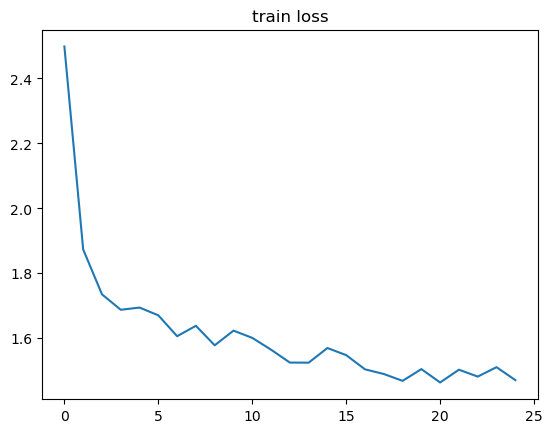

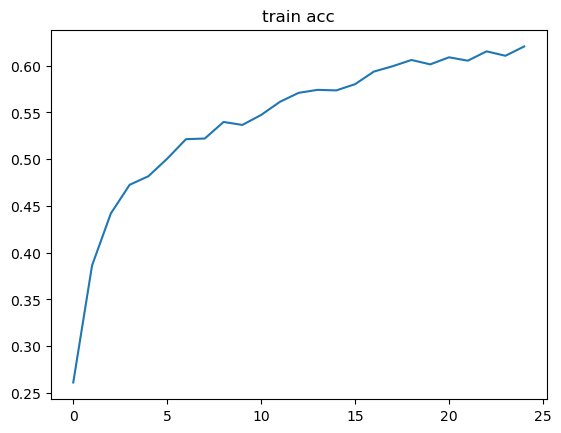

In [3]:
#eps 2.5
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

batch_size=1024
adv_attack_mode ='batch'
epsilon=0.1
dp=True
epochs = 25
patience = 25
save_experiment=False 
verbose=True

adv_attack = None

experiment = Experiment(
    batch_size=batch_size, 
    epochs=epochs, 
    patience=patience, 
    adv_attack=adv_attack, 
    adv_attack_mode=None, 
    epsilon=epsilon, 
    dp=dp, 
    device=device, 
    save_experiment=save_experiment, 
    verbose=verbose, 
    adv_test=True)

experiment._fit()

In [4]:
experiment._validate(experiment.test_loader)

(1.541534819414919, 0.6011, 0.9486)

cuda
Experiment adv-0.1-sample+dp+1024: Loading data
Files already downloaded and verified
Files already downloaded and verified
Experiment adv-0.1-sample+dp+1024: DP on
Experiment adv-0.1-sample+dp+1024: Training started


100%|████████████████████████████████████████████████████████████████████████| 49/49 [03:47<00:00,  4.63s/it]


2.6516377876383403
Experiment adv-0.1-sample+dp+1024: Epoch   1/25, train loss: 3.20e+00, train acc: 0.158


100%|████████████████████████████████████████████████████████████████████████| 49/49 [02:41<00:00,  3.31s/it]


3.049062174160057
Experiment adv-0.1-sample+dp+1024: Epoch   2/25, train loss: 2.27e+00, train acc: 0.240


100%|████████████████████████████████████████████████████████████████████████| 49/49 [03:52<00:00,  4.75s/it]


3.3695191026322946
Experiment adv-0.1-sample+dp+1024: Epoch   3/25, train loss: 2.18e+00, train acc: 0.267


100%|████████████████████████████████████████████████████████████████████████| 49/49 [03:31<00:00,  4.32s/it]


3.6558325276236547
Experiment adv-0.1-sample+dp+1024: Epoch   4/25, train loss: 2.14e+00, train acc: 0.286


100%|████████████████████████████████████████████████████████████████████████| 49/49 [03:39<00:00,  4.49s/it]


3.915523007989198
Experiment adv-0.1-sample+dp+1024: Epoch   5/25, train loss: 2.10e+00, train acc: 0.301


100%|████████████████████████████████████████████████████████████████████████| 49/49 [03:58<00:00,  4.87s/it]


4.158584610512357
Experiment adv-0.1-sample+dp+1024: Epoch   6/25, train loss: 2.08e+00, train acc: 0.311


100%|████████████████████████████████████████████████████████████████████████| 49/49 [03:38<00:00,  4.47s/it]


4.3880040146219255
Experiment adv-0.1-sample+dp+1024: Epoch   7/25, train loss: 2.06e+00, train acc: 0.321


100%|████████████████████████████████████████████████████████████████████████| 49/49 [03:43<00:00,  4.57s/it]


4.60484266313402
Experiment adv-0.1-sample+dp+1024: Epoch   8/25, train loss: 2.04e+00, train acc: 0.325


100%|████████████████████████████████████████████████████████████████████████| 49/49 [03:06<00:00,  3.81s/it]


4.813398392225429
Experiment adv-0.1-sample+dp+1024: Epoch   9/25, train loss: 2.02e+00, train acc: 0.335


100%|████████████████████████████████████████████████████████████████████████| 49/49 [03:23<00:00,  4.15s/it]


5.0159740020153
Experiment adv-0.1-sample+dp+1024: Epoch  10/25, train loss: 2.04e+00, train acc: 0.339


100%|████████████████████████████████████████████████████████████████████████| 49/49 [03:32<00:00,  4.33s/it]


5.208785239333664
Experiment adv-0.1-sample+dp+1024: Epoch  11/25, train loss: 1.99e+00, train acc: 0.345


100%|████████████████████████████████████████████████████████████████████████| 49/49 [03:21<00:00,  4.12s/it]


5.397324006150258
Experiment adv-0.1-sample+dp+1024: Epoch  12/25, train loss: 2.02e+00, train acc: 0.343


100%|████████████████████████████████████████████████████████████████████████| 49/49 [03:41<00:00,  4.51s/it]


5.580067154794406
Experiment adv-0.1-sample+dp+1024: Epoch  13/25, train loss: 1.98e+00, train acc: 0.356


100%|████████████████████████████████████████████████████████████████████████| 49/49 [03:41<00:00,  4.52s/it]


5.757976293745034
Experiment adv-0.1-sample+dp+1024: Epoch  14/25, train loss: 1.98e+00, train acc: 0.354


100%|████████████████████████████████████████████████████████████████████████| 49/49 [03:36<00:00,  4.42s/it]


5.931432361168287
Experiment adv-0.1-sample+dp+1024: Epoch  15/25, train loss: 1.97e+00, train acc: 0.360


100%|████████████████████████████████████████████████████████████████████████| 49/49 [03:41<00:00,  4.52s/it]


6.101690773691344
Experiment adv-0.1-sample+dp+1024: Epoch  16/25, train loss: 1.97e+00, train acc: 0.361


100%|████████████████████████████████████████████████████████████████████████| 49/49 [03:16<00:00,  4.01s/it]


6.2665215901166755
Experiment adv-0.1-sample+dp+1024: Epoch  17/25, train loss: 1.96e+00, train acc: 0.364


100%|████████████████████████████████████████████████████████████████████████| 49/49 [02:52<00:00,  3.51s/it]


6.431352406542007
Experiment adv-0.1-sample+dp+1024: Epoch  18/25, train loss: 1.97e+00, train acc: 0.370


100%|████████████████████████████████████████████████████████████████████████| 49/49 [03:02<00:00,  3.72s/it]


6.588623452378315
Experiment adv-0.1-sample+dp+1024: Epoch  19/25, train loss: 1.96e+00, train acc: 0.373


100%|████████████████████████████████████████████████████████████████████████| 49/49 [03:34<00:00,  4.38s/it]


6.745395266099074
Experiment adv-0.1-sample+dp+1024: Epoch  20/25, train loss: 1.93e+00, train acc: 0.387


100%|████████████████████████████████████████████████████████████████████████| 49/49 [03:29<00:00,  4.28s/it]


6.9008280000842985
Experiment adv-0.1-sample+dp+1024: Epoch  21/25, train loss: 1.94e+00, train acc: 0.386


100%|████████████████████████████████████████████████████████████████████████| 49/49 [02:56<00:00,  3.61s/it]


7.0500296780898015
Experiment adv-0.1-sample+dp+1024: Epoch  22/25, train loss: 1.96e+00, train acc: 0.382


100%|████████████████████████████████████████████████████████████████████████| 49/49 [03:25<00:00,  4.19s/it]


7.1992313560953045
Experiment adv-0.1-sample+dp+1024: Epoch  23/25, train loss: 1.93e+00, train acc: 0.390


100%|████████████████████████████████████████████████████████████████████████| 49/49 [03:20<00:00,  4.08s/it]


7.348211784993296
Experiment adv-0.1-sample+dp+1024: Epoch  24/25, train loss: 1.91e+00, train acc: 0.397


100%|████████████████████████████████████████████████████████████████████████| 49/49 [02:52<00:00,  3.53s/it]


7.490268977994677
Experiment adv-0.1-sample+dp+1024: Epoch  25/25, train loss: 1.95e+00, train acc: 0.393
Experiment adv-0.1-sample+dp+1024: Training finished
7.490268977994677


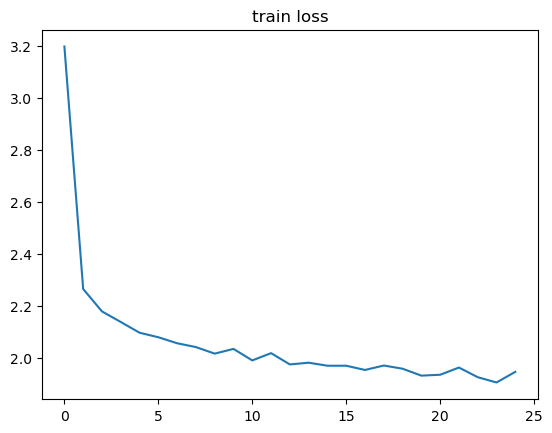

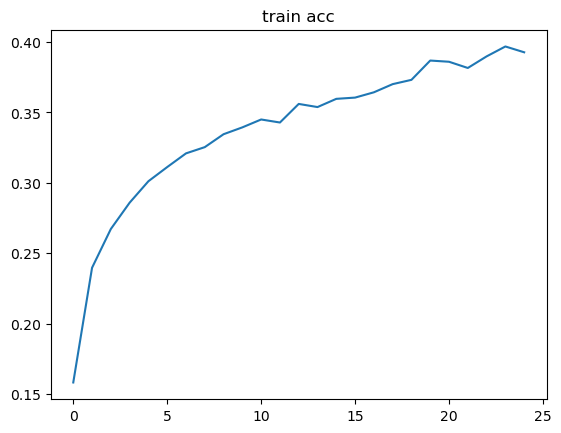

In [3]:
#eps 7.5
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

batch_size=1024
adv_attack_mode ='sample'
epsilon=0.1
dp=True
epochs = 25
patience = 25
save_experiment=False 
verbose=True

adv_attack = True

experiment = Experiment(
    batch_size=batch_size, 
    epochs=epochs, 
    patience=patience, 
    adv_attack=adv_attack, 
    adv_attack_mode=adv_attack_mode, 
    epsilon=epsilon, 
    dp=dp, 
    device=device, 
    save_experiment=save_experiment, 
    verbose=verbose, 
    adv_test=True)

experiment._fit()

In [4]:
experiment._validate(experiment.test_loader)

(2.710708829645168, 0.4103, 0.8086)